In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
from mppi.Utilities import LatticeUtils as LL
import matplotlib.pyplot as plt
import numpy as np
import os, yaml
from scipy.signal import argrelextrema

# Geometrical analysis of Graphene within the hexagonal and the rectangular cell descriptions

Within the standard hexagonal description the graphene lattice configuration (as adopted by QuantumESPRESSO in the ibrav=4 case)
is described by defining the basis vector of the (direct) lattice as
$$
a_1 = a_{lat}(1,0,0) \, ,\quad a_2 = a_{lat}(\frac{-1}{2},\frac{\sqrt{3}}{2},0) \, ,\quad
a_3 = a_{lat}(0,0,\frac{c}{a_{lat}})
$$
so that $c$ vacuum space between two replica of the sheets, expressed in the same units as $a_{lat}$.
We also observe that $\textrm{celldm(3)}=c/a_{lat}$, so it expresses the vacuum distance in terms of 
$a_{lat}$.

In cartesian coordinates the atomic positions of the 2 C atoms read
$$
C_1 = a_{lat}(0,\frac{1}{\sqrt{3}},0) \, \qquad C_2 = a_{lat}(\frac{1}{2},\frac{1}{2\sqrt{3}},0)
$$
and the distance between the nn atoms is $a/\sqrt(3)$.

In an alternative approach we describe the system withing the rectangular unit lattice using a four C atoms base. According to this description (as discussed in https://www.scirp.org/journal/paperinformation?paperid=74995) the basic lattice vectors are
$$
a_1 = a_{lat}(1,0,0) \, ,\quad a_2 = a_{lat}(0,\sqrt{3},0) \, ,\quad
a_3 = a_{lat}(0,0,\frac{c}{a_{lat}})
$$
The C atoms are located in the points
$$
C_1 = a_{lat}(0,0,0) \, , \qquad C_2 = a_{lat}(\frac{1}{2},-\frac{1}{2\sqrt{3}},0)
\, , \qquad C_3 = a_{lat}(0,\frac{1}{\sqrt{3}},0) \, , \qquad C_4 = a_{lat}(\frac{1}{2},\frac{\sqrt{3}}{2},0)
$$  
and the distance between the nn C atoms is as in the standard case, so the lattice constant is the same in the two descriptions.

We build the lattice according to this two description. Note that using the above formula the two lattice structure are shifted so we add an explicit shift on the position
of the atoms in the rectangular description two match the two lattice.

In [27]:
alat = 1
celldm3 = 10

a1_h,a2_h,a3_h = np.array([1,0,0]),np.array([-1./2.,np.sqrt(3)/2.,0]),np.array([0,0,celldm3])
lattice_h = alat*np.array([a1_h,a2_h,a3_h])
C1h_cart = alat*np.array([0,1./np.sqrt(3.),0.])
C2h_cart = alat*np.array([1./2.,1./(2*np.sqrt(3.)),0])
atoms_h = [['C',C1h_cart],['C',C2h_cart]]

a1_r,a2_r,a3_r = np.array([1.,0.,0.]),np.array([0.,np.sqrt(3),0.]),np.array([0.,0.,celldm3])
lattice_r = alat*np.array([a1_r,a2_r,a3_r])
shift = alat*np.array([0.,1./np.sqrt(3.),0.])
C1r_cart = alat*np.array([0,0,0.])+shift
C2r_cart = alat*np.array([1./2.,-1/(2*np.sqrt(3)),0])+shift
C3r_cart = alat*np.array([0,1./(np.sqrt(3.)),0.])+shift
C4r_cart = alat*np.array([1./2.,np.sqrt(3)/2.,0])+shift
atoms_r = [['C',C1r_cart],['C',C2r_cart],['C',C3r_cart],['C',C4r_cart]]

In [28]:
positions_h = LL.build_lattice(lattice_h,atoms_h,10,10,1)
positions_r = LL.build_lattice(lattice_r,atoms_r,10,10,1)

(-1.0, 5.0)

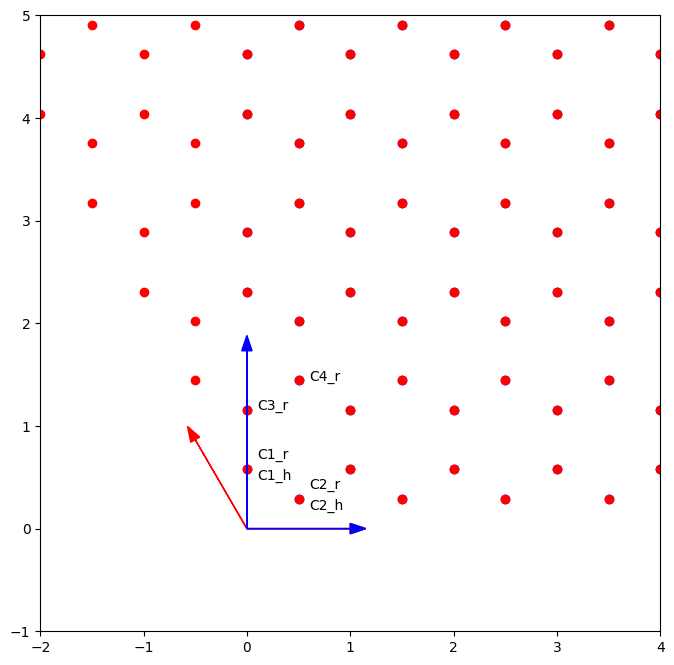

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
for at in positions_r:
    ax.scatter(at[1],at[2],color='blue')
for at in positions_h:
    ax.scatter(at[1],at[2],color='red')

ax.arrow(0,0,lattice_h[0][0],lattice_h[0][1],head_width=0.1,color='red')
ax.arrow(0,0,lattice_h[1][0],lattice_h[1][1],head_width=0.1,color='red')
ax.arrow(0,0,lattice_r[0][0],lattice_r[0][1],head_width=0.1,color='blue')
ax.arrow(0,0,lattice_r[1][0],lattice_r[1][1],head_width=0.1,color='blue')

ax.text(C1r_cart[0]+0.1,C1r_cart[1]+0.1,'C1_r')
ax.text(C2r_cart[0]+0.1,C2r_cart[1]+0.1,'C2_r')
ax.text(C3r_cart[0]+0.1,C3r_cart[1],'C3_r')
ax.text(C4r_cart[0]+0.1,C4r_cart[1],'C4_r')
ax.text(C1h_cart[0]+0.1,C1h_cart[1]-0.1,'C1_h')
ax.text(C2h_cart[0]+0.1,C2h_cart[1]-0.1,'C2_h')

ax.set_xlim(-2,4)
ax.set_ylim(-1,5)

We can build the reciprocal lattice vector and the BZ in the two descriptions.
However I understood that the observed behavior in the band structure obtained within the rectangular description is due to the fact
that the BZ is smaller w.r.t the hexagonal one so the hexagonal K point is outside from the rectangular BZ and there is folding due to 
which the Dirac cone is found in the inner part of the path in the rectangual description.

For our purposes it isi better to start directly from the configuration obtained by removing the H atoms of the AGSL5 structure and set the z position
of the carbons to zero. Then a further small refinement of the x and y position of the atoms is needed to reproduce the equilibrium graphene.
I try to find the optimal positions using a match between the rectangular geometrical analysis compared with the position provided by the AGSL5 structure

In [3]:
inp = I.PwInput(file='../n_5/Input_scf/qe_scf.in')
atoms = inp['atomic_positions']['values'] # provided in angstrom
cell_parameters = inp['cell_parameters']['values'] # provided in angstrom

In [5]:
atoms_Graphene = []
for atom in atoms:
    if atom[0] != 'H':
        atoms_Graphene.append([atom[0],[atom[1][0],atom[1][1],0.0]])
atoms_Graphene

[['C', [-1.792510823, 1.4456517994, 0.0]],
 ['C', [0.6379373039, 1.4235971792, 0.0]],
 ['C', [3.0657768079, 1.4455042995, 0.0]],
 ['C', [-0.5959562906, 0.7133098684, 0.0]],
 ['C', [1.8700368141, 0.7135148531, 0.0]],
 ['C', [-3.0402753064, -0.7719313527, 0.0]],
 ['C', [-0.5959562909, -0.7133098686, 0.0]],
 ['C', [1.8700368138, -0.7135148525, 0.0]],
 ['C', [-1.7925108232, -1.4456518, 0.0]],
 ['C', [0.6379373034, -1.423597179, 0.0]],
 ['C', [3.0657768077, -1.4455042985, 0.0]],
 ['C', [-3.040275306, 0.7719313517, 0.0]]]

In [26]:
lattice = np.array(cell_parameters)
positions = LL.build_lattice(lattice,atoms_Graphene,1,1,1) #3,4
lattice

array([[7.36358849e+00, 1.00000000e-06, 0.00000000e+00],
       [1.00000000e-09, 4.27265581e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.20000000e+01]])

(-8.0, 8.0)

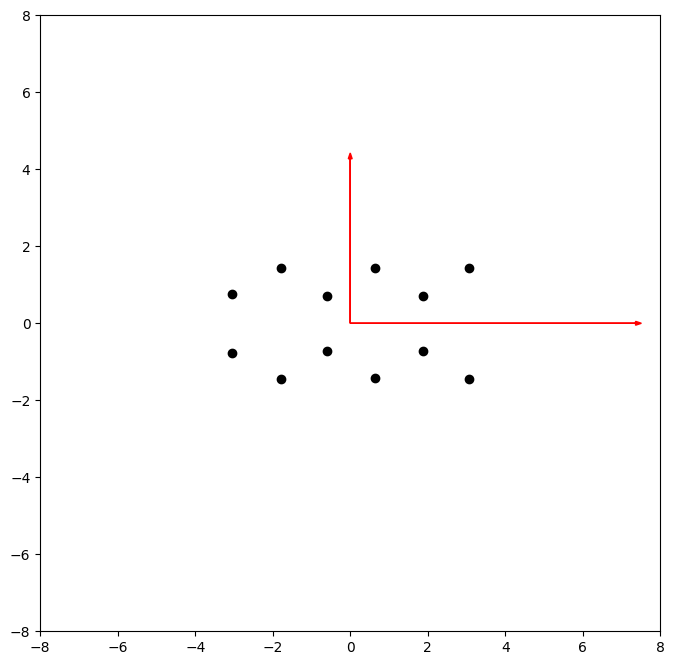

In [28]:
fig, ax = plt.subplots(figsize=(8,8))
for at in positions:
    ax.scatter(at[1],at[2],color='black')
ax.arrow(0,0,lattice[0][0],lattice[0][1],head_width=0.1,color='red')
ax.arrow(0,0,lattice[1][0],lattice[1][1],head_width=0.1,color='red')
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)

We find the optimal atomic positions performing a vc relax in quantum-espresso (see below)

In [ ]:
# RunRules for leonardo
nodes = 1
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads=8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/qe_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_AGSL5',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.QeCalculator(rr)
code.global_options()

# DFT analysis of Graphene with a rectangular cell

This notebook contains the DFT analysis of the Graphene with a rectangular cell. In this way we compute the reference system to which the AGSLn one should approach when the distance among H stripes goes to infinity. 
For simplicity we compute the band structure of this system at DFT level using a modified version of the AGSL5 lattice structure

We start by considering the standard lattice configuration adopted by QuantumESPRESSO in the ibrav=4 case.

The basis vector of the (direct) lattice are defined as
$$
a_1 = a_{lat}(1,0,0) \, ,\quad a_2 = a_{lat}(\frac{-1}{2},\frac{\sqrt{3}}{2},0) \, ,\quad
a_3 = a_{lat}(0,0,\frac{c}{a_{lat}})
$$
so that $c$ vacuum space between two replica of the sheets, expressed in the same units as $a_{lat}$.
We also observe that $\textrm{celldm(3)}=c/a_{lat}$, so it expresses the vacuum distance in terms of 
$a_{lat}$.

In cartesian coordinates the atomic positions of the 2 C atoms read
$$
C_1 = a_{lat}(0,\frac{1}{\sqrt{3}},0) \, \qquad C_2 = a_{lat}(\frac{1}{2},\frac{1}{2\sqrt{3}},0)
$$
and the distance between the nn atoms is $a/\sqrt(3)$.

In [89]:
alat = 1
celldm3 = 10
lattice = alat*np.array([[1,0,0],[-1./2.,np.sqrt(3)/2.,0],[0,0,celldm3]])
C1_cart = alat*np.array([0,1./np.sqrt(3.),0.])
C2_cart = alat*np.array([1./2.,1./(2*np.sqrt(3.)),0])
atoms = [['C',C1_cart],['C',C2_cart]]

In [102]:
positions = LL.build_lattice(lattice,atoms,10,10,1)

(-1.0, 5.0)

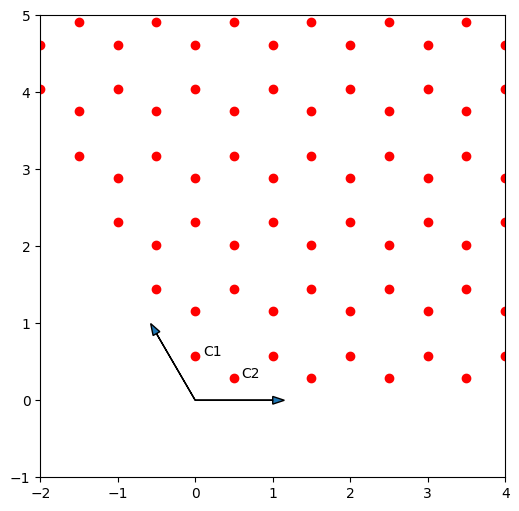

In [104]:
fig, ax = plt.subplots(figsize=(6,6))
for at in positions:
    ax.scatter(at[1],at[2],color='red')
ax.text(C1_cart[0]+0.1,C1_cart[1],'C1')
ax.text(C2_cart[0]+0.1,C2_cart[1],'C2')
ax.arrow(0,0,lattice[0][0],lattice[0][1],head_width=0.1)
ax.arrow(0,0,lattice[1][0],lattice[1][1],head_width=0.1)
ax.set_xlim(-2,4)
ax.set_ylim(-1,5)

Next we describe the system withing the rectangular unit lattice using a four C atoms base.
According to this description (as described in https://www.scirp.org/journal/paperinformation?paperid=74995) the basic lattice vectors
are
$$
a_1 = a_{lat}(1,0,0) \, ,\quad a_2 = a_{lat}(0,\sqrt{3},0) \, ,\quad
a_3 = a_{lat}(0,0,\frac{c}{a_{lat}})
$$
The C atoms are located in the points
$$
C_1 = a_{lat}(0,0,0) \, , \qquad C_2 = a_{lat}(\frac{1}{2},-\frac{1}{2\sqrt{3}},0)
\, , \qquad C_3 = a_{lat}(0,\frac{1}{\sqrt{3}},0) \, , \qquad C_4 = a_{lat}(\frac{1}{2},\frac{\sqrt{3}}{2},0)
$$
and note that the distance between the nn C atoms is $a/\sqrt(3)$ as in the standard case, so the lattice constant is the same in the two descriptions.

In [200]:
alat = 1
celldm3 = 10
lattice = alat*np.array([[1.,0.,0.],[0.,np.sqrt(3),0.],[0.,0.,celldm3]])
C1_cart = alat*np.array([0,0,0.])
C2_cart = alat*np.array([1./2.,-1/(2*np.sqrt(3)),0])
C3_cart = alat*np.array([0,1./(np.sqrt(3.)),0.])
C4_cart = alat*np.array([1./2.,np.sqrt(3)/2.,0])
atoms = [['C',C1_cart],['C',C2_cart],['C',C3_cart],['C',C4_cart]]

In [201]:
np.linalg.norm(C1_cart-C2_cart),np.linalg.norm(C1_cart-C3_cart),np.linalg.norm(C3_cart-C4_cart)

(0.5773502691896258, 0.5773502691896258, 0.5773502691896257)

In [202]:
positions = LL.build_lattice(lattice,atoms,10,10,1)

(-1.0, 5.0)

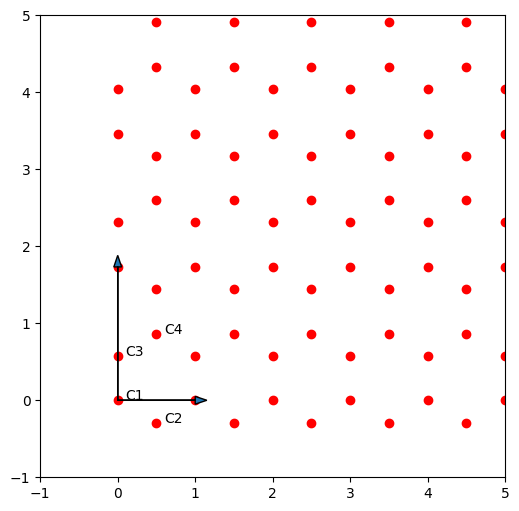

In [203]:
fig, ax = plt.subplots(figsize=(6,6))
for at in positions:
    ax.scatter(at[1],at[2],color='red')
ax.text(C1_cart[0]+0.1,C1_cart[1],'C1')
ax.text(C2_cart[0]+0.1,C2_cart[1],'C2')
ax.text(C3_cart[0]+0.1,C3_cart[1],'C3')
ax.text(C4_cart[0]+0.1,C4_cart[1],'C4')

ax.arrow(0,0,lattice[0][0],lattice[0][1],head_width=0.1)
ax.arrow(0,0,lattice[1][0],lattice[1][1],head_width=0.1)
ax.set_xlim(-1,5)
ax.set_ylim(-1,5)

## GS analysis

In [228]:
run_dir = 'DFT_analysis'

We perform the GS of graphene within the rectangular unit cell. 

We relax the system by varying the lattice parameter. 
The starting input reads

In [229]:
alat = 4.2687/np.sqrt(3)
celldm3 = 12.0/alat
lattice = alat*np.array([[1.,0.,0.],[0.,np.sqrt(3),0.],[0.,0.,celldm3]])
C1_cart = alat*np.array([0,0,0.])
C2_cart = alat*np.array([1./2.,-1/(2*np.sqrt(3)),0])
C3_cart = alat*np.array([0,1./(np.sqrt(3.)),0.])
C4_cart = alat*np.array([1./2.,np.sqrt(3)/2.,0])
atoms = [['C',C1_cart],['C',C2_cart],['C',C3_cart],['C',C4_cart]]

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-7)
inp.set_pseudo_dir('../../pseudos')
inp.add_atom(atom='C',pseudo_name='C_ONCV_PBE.upf',mass=12.011)
inp.set_atomic_positions(atoms,type='angstrom')
inp.set_lattice(0,cell_vectors=lattice,cell_units='angstrom')
inp.set_energy_cutoff(70)
inp.set_atoms_number(4)
inp.set_num_bnds(20)
inp.set_kpoints(points=[10,10,1])
inp['system']['occupations'] = "'smearing'"
inp['system']['smearing'] = "'marzari-vanderbilt'"
inp['system']['degauss'] = 1e-4
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 0,
  'ecutwfc': 70,
  'ntyp': '1',
  'nat': '4',
  'nbnd': 20,
  'occupations': "'smearing'",
  'smearing': "'marzari-vanderbilt'",
  'degauss': 0.0001},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-07},
 'ions': {},
 'cell': {},
 'atomic_species': {'C': [12.011, 'C_ONCV_PBE.upf']},
 'atomic_positions': {'type': 'angstrom',
  'values': [['C', array([0., 0., 0.])],
   ['C', array([ 1.23226755, -0.71145   ,  0.        ])],
   ['C', array([0.    , 1.4229, 0.    ])],
   ['C', array([1.23226755, 2.13435   , 0.        ])]]},
 'kpoints': {'type': 'automatic', 'values': ([10, 10, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {'type': 'angstrom',
  'values': array([[ 2.46453509,  0.        ,  0.        ],
         [ 0.        ,  4.2687    ,  0.        ],
         [ 0.        ,  0.        , 12.

### Calculation of the equilibrium lattice constant

In [230]:
alat_range = 2 # alat percentage variation
alat_num = 5 # number of calculations
alat_span = np.linspace(-alat_range/2,alat_range/2,alat_num)

In [231]:
study = D.Dataset(run_dir=run_dir,num_tasks=5)

for a_span in alat_span:
    a = alat*(1+a_span/100)
    celldm3 = 12.0/a
    lattice = a*np.array([[1.,0.,0.],[0.,np.sqrt(3),0.],[0.,0.,celldm3]])
    C1_cart = a*np.array([0,0,0.])
    C2_cart = a*np.array([1./2.,-1/(2*np.sqrt(3)),0])
    C3_cart = a*np.array([0,1./(np.sqrt(3.)),0.])
    C4_cart = a*np.array([1./2.,np.sqrt(3)/2.,0])
    atoms = [['C',C1_cart],['C',C2_cart],['C',C3_cart],['C',C4_cart]]
        
    idd = {'alat' : a_span}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_atomic_positions(atoms,type='angstrom')
    inp.set_lattice(0,cell_vectors=lattice,cell_units='angstrom')
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)
#study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 5 parallel tasks


In [238]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'DFT_analysis',
 'num_tasks': 5,
 'verbose': True,
 'input': {'control': {'calculation': "'scf'",
   'verbosity': "'high'",
   'prefix': "'alat_-1.0'",
   'outdir': "'./'",
   'pseudo_dir': "'../../pseudos'"},
  'system': {'force_symmorphic': '.true.',
   'ibrav': 0,
   'ecutwfc': 70,
   'ntyp': '1',
   'nat': '4',
   'nbnd': 20,
   'occupations': "'smearing'",
   'smearing': "'marzari-vanderbilt'",
   'degauss': 0.0001},
  'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-07},
  'ions': {},
  'cell': {},
  'atomic_species': {'C': [12.011, 'C_ONCV_PBE.upf']},
  'atomic_positions': {'type': 'angstrom',
   'values': [['C', array([0., 0., 0.])],
    ['C', array([ 1.21994487, -0.7043355 ,  0.        ])],
    ['C', array([0.      , 1.408671, 0.      ])],
    ['C', array([1.21994487, 2.1130065 , 0.        ])]]},
  'kpoints': {'type': 'automatic', 'values': ([10, 10, 1], [0.0, 0.0, 0.0])},
  'cell_parameters': {'type': 'angstrom',
   'values': array([[

In [250]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0, 1, 2, 3, 4]] 

Run the task [0, 1, 2, 3, 4] 
Skip the run ofSkip the run ofSkip the run of   alat_-1.0alat_1.0alat_-0.5


Skip the run of alat_0.0
Skip the run of alat_0.5
Task [0, 1, 2, 3, 4] ended 
 


Text(0, 0.5, 'Total energy (Ha)')

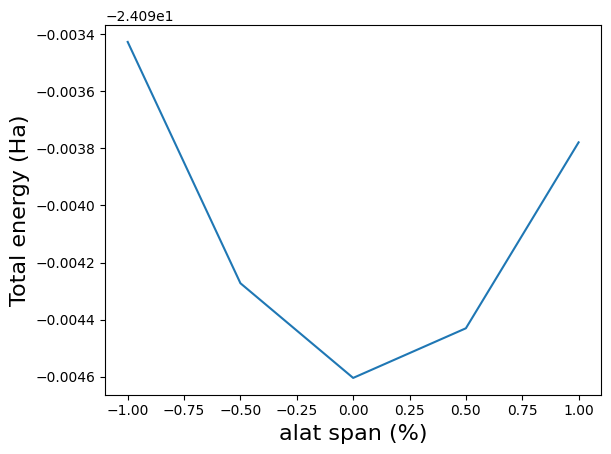

In [245]:
energies = [results[ind] for ind in range(len(alat_span))]
plt.plot(alat_span,energies)
plt.xlabel('alat span (%)',size=16)
plt.ylabel('Total energy (Ha)',size=16)

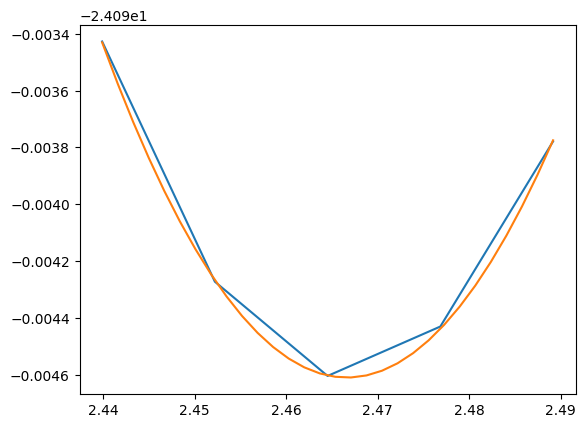

In [246]:
x = [alat*(1+a/100) for a in alat_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,energies,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,energies)
plt.plot(x_fit,y_fit)

In [247]:
x_eq = -coeffs[1]/(2*coeffs[0])
x_eq

2.466658273553815

In [249]:
alat_conv = 2.4667 # Angstrom

### Converged GS

We compute the converged GS

In [314]:
alat = 2.4667 # Angstrom
celldm3 = 12.0/alat
lattice = alat*np.array([[1.,0.,0.],[0.,np.sqrt(3),0.],[0.,0.,celldm3]])
C1_cart = alat*np.array([0,0,0.])
C2_cart = alat*np.array([1./2.,-1/(2*np.sqrt(3)),0])
C3_cart = alat*np.array([0,1./(np.sqrt(3.)),0.])
C4_cart = alat*np.array([1./2.,np.sqrt(3)/2.,0])
atoms = [['C',C1_cart],['C',C2_cart],['C',C3_cart],['C',C4_cart]]

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-7)
inp.set_pseudo_dir('../../pseudos')
inp.add_atom(atom='C',pseudo_name='C_ONCV_PBE.upf',mass=12.011)
inp.set_atomic_positions(atoms,type='angstrom')
inp.set_lattice(0,cell_vectors=lattice,cell_units='angstrom')
inp.set_energy_cutoff(70)
inp.set_atoms_number(4)
inp.set_num_bnds(20)
inp.set_kpoints(points=[9,9,1])
inp['system']['occupations'] = "'smearing'"
inp['system']['smearing'] = "'marzari-vanderbilt'"
inp['system']['degauss'] = 1e-4
#inp

In [315]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged'
inp.set_prefix(D.name_from_id(idd))
study.append_run(id=idd,input=inp,runner=code)
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [316]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of gs_converged
Task [0] ended 
 


In [317]:
results[0].get_gap()

Direct gap system
Gap : 0.00010165523679672717 eV


{'gap': 0.00010165523679672717,
 'direct_gap': 0.00010165523679672717,
 'position_cbm': 15,
 'position_vbm': 15,
 'position_direct_gap': 15}

In [318]:
results[0].lattice

array([[ 4.66138743,  0.        ,  0.        ],
       [ 0.        ,  8.07375987,  0.        ],
       [ 0.        ,  0.        , 22.6767135 ]])

In [338]:
alat_au = alat/U.Constants.Bohr_to_Angstrom
alat_au

4.66138709602763

In [342]:
rec_lattice = LL.get_reciprocal_lattice(results[0].lattice,alat_au,rescale=True)
rec_lattice

array([[0.99999993, 0.        , 0.        ],
       [0.        , 0.57735023, 0.        ],
       [0.        , 0.        , 0.20555832]])

## Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b or the crystal_b type of
pw) and we make usage of the function build_kpath

In [347]:
bands_prefix = 'bands'

# cryst  coords
G_cryst = [0.0,0.0,0.0]
M2_cryst = [0.0,0.5,0.0]
K_cryst = [0.5,0.5,0.0]
M_cryst = [0.5,0.0,0.0]

# cartesian  coords
G = [0.0,0.0,0.0]
M2 = [0.0,0.288675,0.0]
K = [0.5,0.288675,0.0]
M = [0.5,0.0,0.0]

high_sym = {'G':G,'K':K,'M':M,'M2':M2} # useful to label the high-sym point on the path

Convert from cryst to cart

In [348]:
LL.convert_to_cartesian(rec_lattice,M2_cryst)

array([0.        , 0.28867511, 0.        ])

In [349]:
LL.convert_to_cartesian(rec_lattice,K_cryst)

array([0.49999996, 0.28867511, 0.        ])

In [350]:
LL.convert_to_cartesian(rec_lattice,M_cryst)

array([0.49999996, 0.        , 0.        ])

In [351]:
klist = Tools.build_pw_kpath(G,M2,K,M,G,K,numstep=30)
klist

[[0.0, 0.0, 0.0, 30],
 [0.0, 0.288675, 0.0, 30],
 [0.5, 0.288675, 0.0, 30],
 [0.5, 0.0, 0.0, 30],
 [0.0, 0.0, 0.0, 30],
 [0.5, 0.288675, 0.0, 0]]

In [352]:
inp.set_bands(20,force_symmorphic=True,conv_thr=1e-7)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist) #crystal_b
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'pseudo_dir': "'../../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 0,
  'ecutwfc': 70,
  'ntyp': '1',
  'nat': '4',
  'nbnd': 20,
  'occupations': "'smearing'",
  'smearing': "'marzari-vanderbilt'",
  'degauss': 0.0001},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-07},
 'ions': {},
 'cell': {},
 'atomic_species': {'C': [12.011, 'C_ONCV_PBE.upf']},
 'atomic_positions': {'type': 'angstrom',
  'values': [['C', array([0., 0., 0.])],
   ['C', array([ 1.23335   , -0.71207495,  0.        ])],
   ['C', array([0.        , 1.42414991, 0.        ])],
   ['C', array([1.23335   , 2.13622486, 0.        ])]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 30],
   [0.0, 0.288675, 0.0, 30],
   [0.5, 0.288675, 0.0, 30],
   [0.5, 0.0, 0.0, 30],
   [0.0, 0.0, 0.0, 30],
   [0.5, 0.288675, 0.0, 0]]},
 'cell_parameters': {'type': 'angstrom',
  'values'

In [353]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='DFT_analysis/gs_converged.save',skip=False)

delete job_out script: DFT_analysis/job_bands.out
delete log file: DFT_analysis/bands.log
delete xml file: /leonardo_work/IscrC_ICE-SURF/AGSLn/graphene_rect/DFT_analysis/bands.xml
delete folder: /leonardo_work/IscrC_ICE-SURF/AGSLn/graphene_rect/DFT_analysis/bands.save
copy source_dir DFT_analysis/gs_converged.save in the /leonardo_work/IscrC_ICE-SURF/AGSLn/graphene_rect/DFT_analysis/bands.save
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core pw.x -inp bands.in > bands.log
slurm submit:  cd DFT_analysis ; sbatch job_bands.sh
computation bands is running...
computation bands ended


Once that the computation is over we can create an instance of PwBands

In [354]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [355]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'K', 'M', 'M2'],
 [0.0,
  1.5773499999999987,
  0.7886750000000001,
  2.1547002018922283,
  1.0773500000000005,
  0.288675])

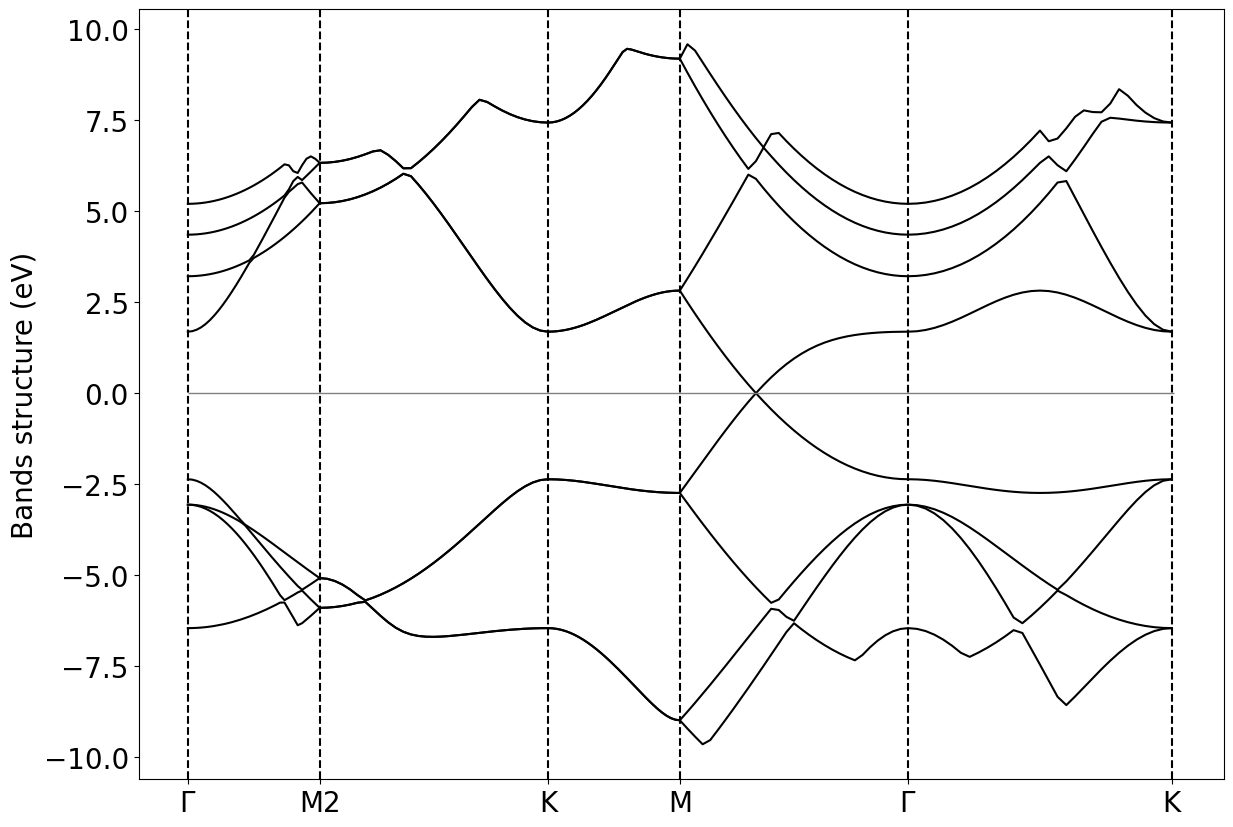

In [363]:
label_size = 20

fig, ax = plt.subplots(figsize=(14, 10))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(4,12)],color='black') #
#bands.plot(plt,selection=[i for i in range(8,10)],color='red')
ax.hlines(0.,0.,2.16,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

# Study based on the AGSL5 configuration

We computed the band structure starting from the structure of the AGSL5 by removing the H atoms and setting the $z$ coordinate of the C atoms to zero

In [370]:
inp = I.PwInput(file='../n_5/Input_scf/qe_scf.in')
atoms = inp['atomic_positions']['values'] # provided in angstrom
cell_parameters = inp['cell_parameters']['values'] # provided in angstrom

In [371]:
atoms,cell_parameters

([['C', [-1.792510823, 1.4456517994, -0.0414672295]],
  ['C', [0.6379373039, 1.4235971792, -0.3172245562]],
  ['C', [3.0657768079, 1.4455042995, -0.0157591793]],
  ['C', [-0.5959562906, 0.7133098684, -0.2503074405]],
  ['C', [1.8700368141, 0.7135148531, -0.2270262819]],
  ['C', [-3.0402753064, -0.7719313527, 0.4823609916]],
  ['H', [-3.0239104491, -1.0594331893, 1.5579425823]],
  ['C', [-0.5959562909, -0.7133098686, -0.2503074405]],
  ['C', [1.8700368138, -0.7135148525, -0.2270262819]],
  ['C', [-1.7925108232, -1.4456518, -0.0414672295]],
  ['C', [0.6379373034, -1.423597179, -0.3172245562]],
  ['C', [3.0657768077, -1.4455042985, -0.0157591793]],
  ['C', [-3.040275306, 0.7719313517, 0.4823609916]],
  ['H', [-3.0239104484, 1.0594331883, 1.5579425823]]],
 [[7.363588492, 1e-06, 0.0], [1e-09, 4.272655813, 0.0], [0.0, 0.0, 12.0]])

We remove the H atoms and set the z positions of all the C ones to zero

In [372]:
atoms_Graphene = []
for atom in atoms:
    if atom[0] != 'H':
        atoms_Graphene.append([atom[0],[atom[1][0],atom[1][1],0.0]])
atoms_Graphene

[['C', [-1.792510823, 1.4456517994, 0.0]],
 ['C', [0.6379373039, 1.4235971792, 0.0]],
 ['C', [3.0657768079, 1.4455042995, 0.0]],
 ['C', [-0.5959562906, 0.7133098684, 0.0]],
 ['C', [1.8700368141, 0.7135148531, 0.0]],
 ['C', [-3.0402753064, -0.7719313527, 0.0]],
 ['C', [-0.5959562909, -0.7133098686, 0.0]],
 ['C', [1.8700368138, -0.7135148525, 0.0]],
 ['C', [-1.7925108232, -1.4456518, 0.0]],
 ['C', [0.6379373034, -1.423597179, 0.0]],
 ['C', [3.0657768077, -1.4455042985, 0.0]],
 ['C', [-3.040275306, 0.7719313517, 0.0]]]

In [373]:
lattice = np.array(cell_parameters)
positions = LL.build_lattice(lattice,atoms_Graphene,5,5,1) #3,4

(0.0, 20.0)

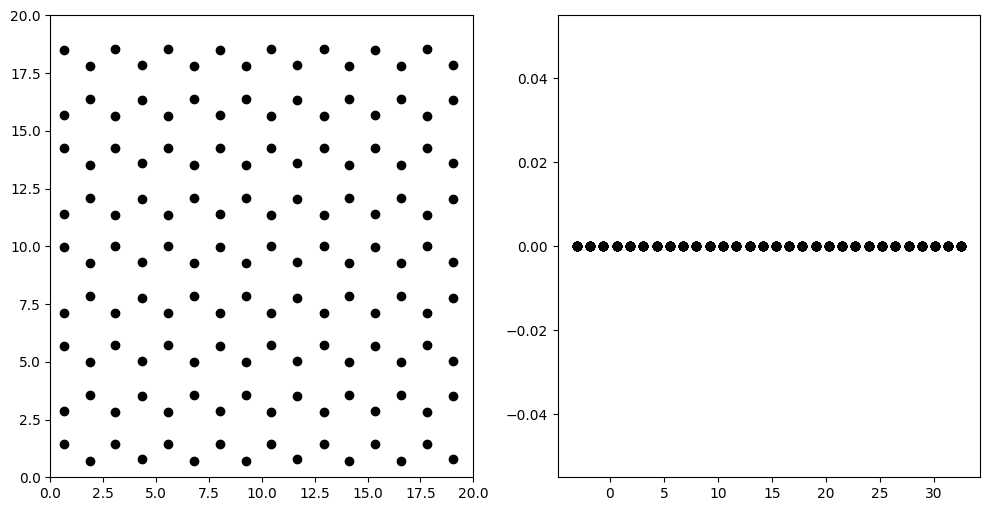

In [374]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
for at in positions:
    if at[0] == 'C': color = 'black'
    if at[0] == 'H': color = 'red'
    ax[0].scatter(at[1],at[2],color=color)
for at in positions:
    if at[0] == 'C': color = 'black'
    if at[0] == 'H': color = 'red'
    ax[1].scatter(at[1],at[3],color=color)
ax[0].set_xlim(0.,20.)
ax[0].set_ylim(0.,20.)

## Converged GS

In [375]:
run_dir = 'DFT_analysis'

We use the input file 'Input_scf/qe_scf.in' as starting point for the DFT analysis

In [383]:
inp = I.PwInput(file='../n_5/Input_scf/qe_scf.in')
inp.set_scf(force_symmorphic=True,conv_thr=1e-7)
inp.set_pseudo_dir('../../pseudos')
inp['atomic_species'] = {}
inp.add_atom(atom='C',pseudo_name='C_ONCV_PBE.upf',mass=12.011)
inp.set_atoms_number(12)
inp.set_atomic_positions(atoms_Graphene,type='angstrom')
inp.set_num_bnds(26)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'restart_mode': "'from_scratch'",
  'wf_collect': '.false.',
  'pseudo_dir': "'../../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 0,
  'nat': '12',
  'ntyp': '1',
  'ecutwfc': 70,
  'nbnd': 26,
  'occupations': "'fixed'",
  'degauss': 0.0,
  'smearing': "'gaussian'"},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-07},
 'ions': {},
 'cell': {},
 'atomic_species': {'C': [12.011, 'C_ONCV_PBE.upf']},
 'atomic_positions': {'type': 'angstrom',
  'values': [['C', [-1.792510823, 1.4456517994, 0.0]],
   ['C', [0.6379373039, 1.4235971792, 0.0]],
   ['C', [3.0657768079, 1.4455042995, 0.0]],
   ['C', [-0.5959562906, 0.7133098684, 0.0]],
   ['C', [1.8700368141, 0.7135148531, 0.0]],
   ['C', [-3.0402753064, -0.7719313527, 0.0]],
   ['C', [-0.5959562909, -0.7133098686, 0.0]],
   ['C', [1.8700368138, -0.7135148525, 0.0]],
   ['C', [-1.7925108232, -1.4456518, 0.0]]

In [384]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged_from_AGSL5'
inp.set_prefix(D.name_from_id(idd))
study.append_run(id=idd,input=inp,runner=code)
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [385]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core pw.x -inp gs_converged_from_AGSL5.in > gs_converged_from_AGSL5.log
slurm submit:  cd DFT_analysis ; sbatch job_gs_converged_from_AGSL5.sh
computation gs_converged_from_AGSL5 is running...
computation gs_converged_from_AGSL5 ended
Task [0] ended 
 


In [386]:
results[0].get_gap()

Direct gap system
Gap : 0.010944219879373218 eV


{'gap': 0.010944219879373218,
 'direct_gap': 0.010944219879373218,
 'position_cbm': 0,
 'position_vbm': 0,
 'position_direct_gap': 0}

## Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b or the crystal_b type of
pw) and we make usage of the function build_kpath

In [387]:
bands_prefix = 'bands'

# cryst  coords
G_cryst = [0.0,0.0,0.0]
M2_cryst = [0.0,0.5,0.0]
K_cryst = [0.5,0.5,0.0]
M_cryst = [0.5,0.0,0.0]

# cartesian  coords
G = [0.0,0.0,0.0]
M2 = [0.0,0.8617109,0.0]
K = [0.5,0.8617109,0.0]
M = [0.5,0.0,0.0]

high_sym = {'G':G,'K':K,'M':M,'M2':M2} # useful to label the high-sym point on the path

In [388]:
klist = Tools.build_pw_kpath(G,M2,K,M,G,K,numstep=30)
klist

[[0.0, 0.0, 0.0, 30],
 [0.0, 0.8617109, 0.0, 30],
 [0.5, 0.8617109, 0.0, 30],
 [0.5, 0.0, 0.0, 30],
 [0.0, 0.0, 0.0, 30],
 [0.5, 0.8617109, 0.0, 0]]

In [389]:
inp.set_bands(30,force_symmorphic=True,conv_thr=1e-7)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist) #crystal_b
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'restart_mode': "'from_scratch'",
  'wf_collect': '.false.',
  'pseudo_dir': "'../../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 0,
  'nat': '12',
  'ntyp': '1',
  'ecutwfc': 70,
  'nbnd': 30,
  'occupations': "'fixed'",
  'degauss': 0.0,
  'smearing': "'gaussian'"},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-07},
 'ions': {},
 'cell': {},
 'atomic_species': {'C': [12.011, 'C_ONCV_PBE.upf']},
 'atomic_positions': {'type': 'angstrom',
  'values': [['C', [-1.792510823, 1.4456517994, 0.0]],
   ['C', [0.6379373039, 1.4235971792, 0.0]],
   ['C', [3.0657768079, 1.4455042995, 0.0]],
   ['C', [-0.5959562906, 0.7133098684, 0.0]],
   ['C', [1.8700368141, 0.7135148531, 0.0]],
   ['C', [-3.0402753064, -0.7719313527, 0.0]],
   ['C', [-0.5959562909, -0.7133098686, 0.0]],
   ['C', [1.8700368138, -0.7135148525, 0.0]],
   ['C', [-1.7925108232, -1.4456518, 0.0

In [391]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='DFT_analysis/gs_converged_from_AGSL5.save')

delete job_out script: DFT_analysis/job_bands.out
delete log file: DFT_analysis/bands.log
delete folder: /leonardo_work/IscrC_ICE-SURF/AGSLn/graphene_rect/DFT_analysis/bands.save
copy source_dir DFT_analysis/gs_converged_from_AGSL5.save in the /leonardo_work/IscrC_ICE-SURF/AGSLn/graphene_rect/DFT_analysis/bands.save
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core pw.x -inp bands.in > bands.log
slurm submit:  cd DFT_analysis ; sbatch job_bands.sh
computation bands is running...
computation bands ended


Once that the computation is over we can create an instance of PwBands

In [392]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [393]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'K', 'M', 'M2'],
 [0.0,
  2.723421799999998,
  1.361710899999999,
  3.7196876657099534,
  2.2234217999999997,
  0.8617109])

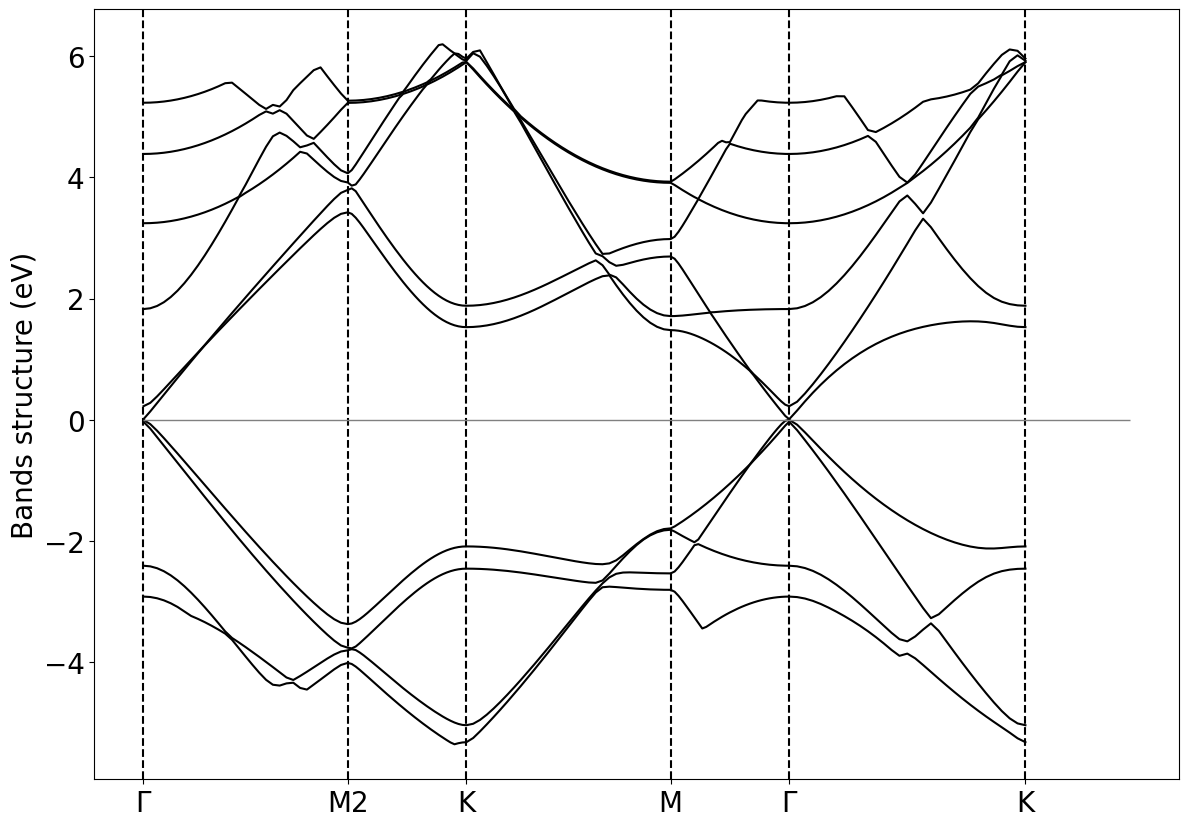

In [394]:
label_size = 20

fig, ax = plt.subplots(figsize=(14, 10))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(20,30)],color='black') #
#bands.plot(plt,selection=[i for i in range(26,30)],color='red')
ax.hlines(0.,0.,4.16,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")